## Importation des bibliothèques, du modèle ResNet-50 et du jeu de données ImageNet

**Définition :** Pour $\alpha\in ]0,1[$, on dit d'un ensemble de prédictions $\mathcal{C}$ admet une **couverture** de $1-\alpha$ s'il vérifie :
<center> $\mathbb{P}(Y\in\mathcal{C}) \geq 1-\alpha$.  </center> <div style="text-align: right"> $(1)$ </div>

**Définition :** Pour $\alpha\in ]0,1[$, on dit d'un ensemble de prédictions $\mathcal{C}$ admet une **couverture exacte** de $1-\alpha$ s'il vérifie :
<center> $\mathbb{P}(Y\in\mathcal{C}) = 1-\alpha$.  </center>

In [1]:
import os
import random
from time import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

model = ResNet50(weights = 'imagenet')  # Load the ResNet50 model with pre-trained weights

imagenet_train_dir = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train'
print('ok')

2024-11-06 10:04:12.242872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 10:04:12.243004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 10:04:12.406972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ok


## Fonction de traitement d'images et extraction de données sur les classes

In [2]:
def load_and_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image with target size
    x = image.img_to_array(img)  # Convert the image to array
    x = np.expand_dims(x, axis=0)  # Expand the dimensions
    x = preprocess_input(x)  # Preprocess the input
    return x

with open('/kaggle/input/imagenet-object-localization-challenge/LOC_synset_mapping.txt','r') as file:
    file_read = file.read()

class_names = list(map(lambda sublist: [sublist[:9],sublist[10:].split(', ')], file_read.split('\n')))[:-1]
# class_names and preds are linked by same index
class_dict = {elt[0]:elt[1] for elt in class_names}

list_classes = [sublist[0] for sublist in class_names]
print('ok')

ok


La fonction `load_and_preprocess_img` fait un traitement sur une image donnée pour pouvoir l'implanter dans le modèle ResNet-50.

Le fichier **LOC_synset_mapping.txt** établit une correspondance entre le nom du dossier d'une classe dans ImageNet (par exemple `'n02417914'`) et le nom véritable de la classe (ici "ibex, Capra ibrex", soit des bouquetins).

Le dictionnaire `class_dict` nous permet de retranscrire ces relations sur Python et de travailler avec. La liste `list_classes` liste l'ensemble de ces noms de dossiers.

In [7]:
list_classes[350]

'n02417914'

In [6]:
class_dict[list_classes[350]]

['ibex', 'Capra ibex']

## Première tâche : déterminer la pire classe pour notre modèle

La première étape consiste à faire une fonction `compare_labels` qui, pour une image provenant des données d'entrainement, détermine si la classe prédite par le modèle est correcte ou non.

In [3]:
def compare_labels(img_path):
    # Return the possible labels for top prediction
    # "verbose = 0" in model.predict() disable the output
    preds = list(model.predict(load_and_preprocess_img(img_path), verbose = 0)[0])
    argmax = preds.index(max(preds))
    
    real_folder = os.path.relpath(img_path, imagenet_train_dir)[:9]
    
    pred_labels = class_names[argmax][1]
    real_labels = class_dict[real_folder]
    
    return pred_labels == real_labels
print('ok')

ok


Pour connaître la pire classe en précision, nous devons faire passer **l'ensemble** des données d'entraînement dans notre modèle et utiliser la fonction `compare_labels` pour comparer la classe sortie par le modèle et celle attendue.

Cependant, il y a environ 1,3 million d'images à traiter et tester. Le processus risque alors de prendre beaucoup de temps. C'est pourquoi il a fallu le faire en plusieurs fois. Vous trouverez ci-dessous les codes pour commencer la tâche et la reprendre là où on s'est arrêté dernièrement (les valeurs des variables font office d'illustration).

### Code pour tout traiter en une fois

**PS : veuillez ne PAS exécuter les 4 prochains blocs de code, le temps d'exécution estimé de cette tâche est de plus de *28 heures* et les résultats sont déjà présents au bloc de code qui suit.**

In [ ]:
list_classes = os.listdir(imagenet_train_dir)
# Performances de ResNet50

set_percent = set()

list_percent = np.arange(0,100+0.25,0.25)
nb_images_train = 1_281_167 # nb_images_train = sum(nb_imgs_perclass)


per_class = 1000*[0]

total_perf = 0
current_folder = 0
count = 0

start = time()

# Pour chaque classe
for folder in list_classes:
    
    # Pour chaque image de cette classe
    for file in os.listdir(os.path.join(imagenet_train_dir,folder)):
        picture = os.path.join(imagenet_train_dir,folder,file)
        # Comparaison de la classe prédite à la vraie
        if compare_labels(picture):
            per_class[current_folder] += 1   # Pour la précision par classe
            total_perf += 1                  # Pour la précision globale
            
        # Pour s'assurer de ne pas oublier d'image
        count += 1
        
        # Affichage de la progression
        percent = int(count*10000/nb_images_train)/100
        if percent in list_percent:
            if percent not in set_percent:
                print(f"{percent}% fait")
                print(f"Temps écoulé depuis début : {time()-start} s.")
                set_percent.add(percent)

# Calcul des précisions par classe
per_class = [per_class[i]/nb_imgs_perclass[i] for i in range(1000)]

end = time()

print("Score sur la totalité des données : {:.3f}".format(total_perf / nb_images_train))
print(f"Temps écoulé pour  : {end-start} s.",'\n')

print("per_class :\n" + str(per_class), "total_perf : "+str(total_perf), "count : "+str(count), sep = 2*'\n')

### Code pour le faire en plusieurs fois

Lorsqu'on reprend le processus après une interruption, ce n'est pas toujours dans des conditions idéales : l'interruption se fait souvent lorsque nous n'avons pas complètement terminé la classe en cours. Il est alors **impératif** de savoir précisément à *quelle image* de *quelle classe* le processus est stoppé. Pour cela, on introduit de nouvelles variables pour suivre de très près ceci et être certain de ne pas refaire une image déjà testée ou en sauter une.

En reprenant là où on s'est arrêté, on complète dans un premier temps la classe en cours. Le code correspondant se trouve ci-dessous :

In [ ]:
# 90.75% fait
from time import time
list_classes = os.listdir(imagenet_train_dir)

total_perf = 936246
count = 1195668
current_folder = 932
current_folder_count = 451

# Finir seule une classe particulière
start = time()
folder = list_classes[current_folder]
for file in os.listdir(os.path.join(imagenet_train_dir,folder))[current_folder_count:]:
    picture = os.path.join(imagenet_train_dir,folder,file)
    if compare_labels(picture):
        per_class[current_folder] += 1
        total_perf += 1
        
    count += 1
    current_folder_count += 1
end = time()
print("Temps écoulé en secondes :",end-start)

Seulement dans un second temps, il est réellement possible de reprendre la tâche après l'interruption. Juste avant d'exécuter le même code, nous devons mettre à jour les variables de suivi, sans quoi on répèterais une partie de la progression complétée jusqu'ici :
* `total_perf` : nombre d'images correctes sur l'ensemble de la base
* `count` : nombre d'images traitées jusqu'ici
* `current_folder` : classe actuellement traitée
* `current_folder_count` : nombre d'images traitée dans la classe actuelle

In [2]:
total_perf,count,current_folder,current_folder_count

(936902, 1196517, 932, 1300)

Maintenant on informe le programme de ces nouvelles valeurs et on reprend.

In [ ]:
list_classes = os.listdir(imagenet_train_dir)
# Performances de ResNet50

set_percent = set(np.arange(0,93.25+0.25,0.25))

list_percent = np.arange(0,100+0.25,0.25)
nb_images_train = 1_281_167 # nb_images_train = sum(nb_imgs_perclass)

# 93.39% already done
per_class = 1000*[0]
#per_class[607-1] = 0
total_perf = 936902 # = sum(per_class) sans per_class[607-1]
count = 1196517 # = sum(nb_imgs_perclass[:607])
current_folder = 933-1 # On reprend à partir de la classe 933

print(f"{int(count*10000/nb_images_train)/100}% fait")
start = time()
for folder in list_classes[current_folder+1:]: # on reprend bien à partir de la classe 933
    current_folder_count = 0
    current_folder += 1
    
    for file in os.listdir(os.path.join(imagenet_train_dir,folder)):
        picture = os.path.join(imagenet_train_dir,folder,file)
        if compare_labels(picture):
            per_class[current_folder] += 1
            total_perf += 1
            
        count += 1
        current_folder_count += 1
        
        percent = int(count*10000/nb_images_train)/100
        if percent in list_percent:
            if percent not in set_percent:
                print(f"{percent}% fait")
                print(f"Temps écoulé depuis début : {time()-start} s.")
                set_percent.add(percent)


per_class = [per_class[i]/nb_imgs_perclass[i] for i in range(1000)]
#total_perf /= nb_images_train
end = time()

print("Score sur la totalité des données : {:.3f}".format(total_perf / nb_images_train))
print(f"Temps écoulé pour  : {end-start} s.",'\n')

print("per_class :\n" + str(per_class), "total_perf : "+str(total_perf), "count : "+str(count), sep = 2*'\n')

Une fois le processus entièrement terminé, on récupère les variables utiles pour mesurer la précision de notre modèle. Ainsi, le modèle **ResNet-50** a une précision d'environ **78,46%**.

In [5]:
# global_perf : Score sur la totalité des données pour le modèle ResNet50

total_perf = 1_005_187
nb_images_train = 1_281_187
global_perf = total_perf/nb_images_train

global_perf*100

78.45747732376303

In [3]:
# Scores par classe pour le modèle ResNet50
per_class = [0.9069230769230769, 0.933076923076923, 0.9138461538461539, 0.7515384615384615, 0.8407692307692308, 0.7292307692307692, 0.8584615384615385, 0.8869230769230769, 0.8184615384615385, 0.9476923076923077, 0.9076923076923077, 0.9638461538461538, 0.8846153846153846, 0.8915384615384615, 0.953076923076923, 0.9146153846153846, 0.8253846153846154, 0.9292307692307692, 0.8738461538461538, 0.9207692307692308, 0.8815384615384615, 0.8076923076923077, 0.9307692307692308, 0.8115384615384615, 0.9515384615384616, 0.9353846153846154, 0.6453846153846153, 0.9007692307692308, 0.8561538461538462, 0.8923076923076924, 0.8469230769230769, 0.8746153846153846, 0.666923076923077, 0.803076923076923, 0.8138461538461539, 0.6984615384615385, 0.5907692307692308, 0.85, 0.7976923076923077, 0.8023076923076923, 0.6515384615384615, 0.7176923076923077, 0.8761538461538462, 0.8370635631154879, 0.7146153846153847, 0.9307692307692308, 0.6330769230769231, 0.8569230769230769, 0.9007692307692308, 0.75, 0.806923076923077, 0.9218009478672986, 0.7123076923076923, 0.8084615384615385, 0.6784615384615384, 0.7961538461538461, 0.8407692307692308, 0.8823076923076923, 0.6707692307692308, 0.59, 0.40076923076923077, 0.803076923076923, 0.5387488328664799, 0.83, 0.7392307692307692, 0.7807692307692308, 0.6723076923076923, 0.7215384615384616, 0.33615384615384614, 0.9053846153846153, 0.8507692307692307, 0.8261538461538461, 0.7623076923076924, 0.5153846153846153, 0.6253846153846154, 0.8738461538461538, 0.8369230769230769, 0.85, 0.86, 0.8861538461538462, 0.8746153846153846, 0.9115384615384615, 0.5784615384615385, 0.8838461538461538, 0.9561538461538461, 0.8692307692307693, 0.7061538461538461, 0.95, 0.93, 0.9407692307692308, 0.9684615384615385, 0.8861538461538462, 0.9153846153846154, 0.8823076923076923, 0.9023076923076923, 0.9223076923076923, 0.916923076923077, 0.9184615384615384, 0.8483786152497809, 0.8415384615384616, 0.9538461538461539, 0.5838461538461538, 0.916923076923077, 0.8372641509433962, 0.8284615384615385, 0.9584615384615385, 0.8653846153846154, 0.9507692307692308, 0.7315384615384616, 0.8246153846153846, 0.7938461538461539, 0.8023076923076923, 0.7915384615384615, 0.7853846153846153, 0.8446153846153847, 0.8761538461538462, 0.8769230769230769, 0.9446153846153846, 0.6861538461538461, 0.7507692307692307, 0.8538461538461538, 0.8023076923076923, 0.7284615384615385, 0.8153846153846154, 0.6853846153846154, 0.8469230769230769, 0.7553846153846154, 0.8738461538461538, 0.81, 0.9184615384615384, 0.9715384615384616, 0.7953846153846154, 0.8715384615384615, 0.8523076923076923, 0.7946153846153846, 0.9007692307692308, 0.933076923076923, 0.9307692307692308, 0.9276923076923077, 0.9407692307692308, 0.833076923076923, 0.9153846153846154, 0.9284615384615384, 0.9323076923076923, 0.8384615384615385, 0.963076923076923, 0.8861538461538462, 0.8495652173913043, 0.9069230769230769, 0.8792307692307693, 0.8315384615384616, 0.66, 0.7383419689119171, 0.8115384615384615, 0.7715384615384615, 0.7315384615384616, 0.8376923076923077, 0.8453846153846154, 0.6465116279069767, 0.6030769230769231, 0.8176923076923077, 0.8353846153846154, 0.6923076923076923, 0.7423076923076923, 0.8028169014084507, 0.6366120218579235, 0.6331707317073171, 0.5291777188328912, 0.6356589147286822, 0.8676923076923077, 0.7107692307692308, 0.6946153846153846, 0.7376923076923076, 0.7953846153846154, 0.8476923076923077, 0.6951219512195121, 0.7138461538461538, 0.7476923076923077, 0.82, 0.6069230769230769, 0.5361538461538462, 0.9038155802861685, 0.7938461538461539, 0.8397486252945797, 0.7046153846153846, 0.5776923076923077, 0.6492307692307693, 0.5961538461538461, 0.6857727737973388, 0.6230769230769231, 0.7574786324786325, 0.8823076923076923, 0.7207692307692307, 0.6453846153846153, 0.828719723183391, 0.803076923076923, 0.6184615384615385, 0.7515384615384615, 0.6407692307692308, 0.8392307692307692, 0.5784615384615385, 0.6715384615384615, 0.7153846153846154, 0.8438461538461538, 0.5584615384615385, 0.7269230769230769, 0.7750410509031199, 0.6761538461538461, 0.6176923076923077, 0.8215384615384616, 0.8369230769230769, 0.8276923076923077, 0.7715384615384615, 0.8715384615384615, 0.8715384615384615, 0.7246153846153847, 0.8453846153846154, 0.8561538461538462, 0.8446153846153847, 0.7476923076923077, 0.7261538461538461, 0.8544891640866873, 0.7215384615384616, 0.7407692307692307, 0.8676923076923077, 0.84, 0.71, 0.6061538461538462, 0.8992307692307693, 0.8684615384615385, 0.6523076923076923, 0.6076923076923076, 0.6776923076923077, 0.7523076923076923, 0.7784615384615384, 0.7576923076923077, 0.7423076923076923, 0.7669230769230769, 0.7053846153846154, 0.8715384615384615, 0.5438461538461539, 0.5269230769230769, 0.7084615384615385, 0.7046153846153846, 0.806923076923077, 0.7938461538461539, 0.7530769230769231, 0.9115384615384615, 0.56, 0.7084615384615385, 0.5215384615384615, 0.9346153846153846, 0.7830188679245284, 0.8353846153846154, 0.8415384615384616, 0.8538461538461538, 0.7453846153846154, 0.7346153846153847, 0.8546153846153847, 0.8523076923076923, 0.8938461538461538, 0.9069230769230769, 0.7411214953271028, 0.7015384615384616, 0.6438461538461538, 0.5515384615384615, 0.54, 0.7692307692307693, 0.8622516556291391, 0.693076923076923, 0.796923076923077, 0.7069230769230769, 0.8246153846153846, 0.6861538461538461, 0.813076923076923, 0.8984615384615384, 0.8784615384615385, 0.6861538461538461, 0.6738461538461539, 0.78, 0.7015384615384616, 0.7253846153846154, 0.4207692307692308, 0.8869230769230769, 0.9184615384615384, 0.6407692307692308, 0.8138461538461539, 0.7823076923076923, 0.7646153846153846, 0.933076923076923, 0.8238461538461539, 0.8646153846153846, 0.9215384615384615, 0.9346153846153846, 0.8853846153846154, 0.8546153846153847, 0.9446153846153846, 0.84, 0.7592307692307693, 0.916923076923077, 0.9130769230769231, 0.9084615384615384, 0.6653846153846154, 0.7361538461538462, 0.7546153846153846, 0.8476923076923077, 0.81, 0.8661538461538462, 0.8284615384615385, 0.806923076923077, 0.7615384615384615, 0.7561538461538462, 0.6784615384615384, 0.7884615384615384, 0.7976923076923077, 0.7038461538461539, 0.7884615384615384, 0.8638461538461538, 0.8830769230769231, 0.8692307692307693, 0.7538461538461538, 0.9707692307692307, 0.9176923076923077, 0.98, 0.9376923076923077, 0.916923076923077, 0.9392307692307692, 0.9107692307692308, 0.8853846153846154, 0.8592307692307692, 0.816923076923077, 0.8123076923076923, 0.9084615384615384, 0.9215384615384615, 0.8684615384615385, 0.8283582089552238, 0.8738461538461538, 0.7846153846153846, 0.8746153846153846, 0.94, 0.96, 0.6469230769230769, 0.7284615384615385, 0.786923076923077, 0.9046153846153846, 0.6061538461538462, 0.74, 0.9476923076923077, 0.74, 0.7092307692307692, 0.8738461538461538, 0.92, 0.7953846153846154, 0.7446153846153846, 0.943076923076923, 0.8976923076923077, 0.5192307692307693, 0.7423076923076923, 0.6507692307692308, 0.7176923076923077, 0.7230769230769231, 0.9015384615384615, 0.8930769230769231, 0.8738461538461538, 0.7938461538461539, 0.9215384615384615, 0.91, 0.7523076923076923, 0.8307692307692308, 0.7976923076923077, 0.7923076923076923, 0.6807692307692308, 0.8369230769230769, 0.7715384615384615, 0.6876923076923077, 0.8007692307692308, 0.9230769230769231, 0.76, 0.7938461538461539, 0.7661538461538462, 0.4753846153846154, 0.5892307692307692, 0.85, 0.8984615384615384, 0.7553846153846154, 0.7438461538461538, 0.8076923076923077, 0.9438461538461539, 0.9676923076923077, 0.7438461538461538, 0.7527896995708154, 0.8707692307692307, 0.9143446852425181, 0.8530769230769231, 0.8307692307692308, 0.7084615384615385, 0.9261538461538461, 0.8761538461538462, 0.8569230769230769, 0.8361538461538461, 0.5761538461538461, 0.8238461538461539, 0.7369230769230769, 0.9061538461538462, 0.8630769230769231, 0.9292307692307692, 0.806923076923077, 0.8184615384615385, 0.7884615384615384, 0.6091331269349846, 0.9084615384615384, 0.7753846153846153, 0.6492307692307693, 0.6753846153846154, 0.7646153846153846, 0.5915384615384616, 0.8907692307692308, 0.8661538461538462, 0.6116504854368932, 0.666923076923077, 0.8515384615384616, 0.7076923076923077, 0.8269230769230769, 0.7823076923076923, 0.7776923076923077, 0.8946153846153846, 0.7714762301918265, 0.7476923076923077, 0.7838461538461539, 0.8415384615384616, 0.87, 0.8138461538461539, 0.7623076923076924, 0.7538461538461538, 0.7984615384615384, 0.7138461538461538, 0.4876923076923077, 0.8846153846153846, 0.7876923076923077, 0.902398676592225, 0.7946153846153846, 0.8492307692307692, 0.7184615384615385, 0.8630769230769231, 0.83, 0.8507692307692307, 0.6961538461538461, 0.74, 0.8738461538461538, 0.77, 0.9007692307692308, 0.8823076923076923, 0.786923076923077, 0.7638461538461538, 0.7230769230769231, 0.8061538461538461, 0.6846153846153846, 0.6553846153846153, 0.89, 0.6761538461538461, 0.8184615384615385, 0.6576923076923077, 0.7430769230769231, 0.686923076923077, 0.693076923076923, 0.8154761904761905, 0.946923076923077, 0.88, 0.8207692307692308, 0.7169230769230769, 0.81, 0.8246153846153846, 0.8761538461538462, 0.6515384615384615, 0.7923076923076923, 0.9246153846153846, 0.9084615384615384, 0.7346153846153847, 0.8392307692307692, 0.64, 0.8369230769230769, 0.7537942664418212, 0.5023076923076923, 0.91, 0.7430769230769231, 0.5815384615384616, 0.683076923076923, 0.6376923076923077, 0.6907692307692308, 0.9, 0.8484615384615385, 0.8668341708542714, 0.7792307692307693, 0.7961538461538461, 0.6346153846153846, 0.8538461538461538, 0.9138461538461539, 0.7746153846153846, 0.8276923076923077, 0.6551077788191191, 0.9346153846153846, 0.6812439261418853, 0.7192307692307692, 0.7651646447140381, 0.6946153846153846, 0.6907692307692308, 0.8023076923076923, 0.7615131578947368, 0.7123076923076923, 0.696923076923077, 0.8684615384615385, 0.7153846153846154, 0.7623076923076924, 0.6923076923076923, 0.6915384615384615, 0.7284615384615385, 0.7038461538461539, 0.8415384615384616, 0.7107692307692308, 0.7823076923076923, 0.8738461538461538, 0.7759056444818871, 0.8507692307692307, 0.64, 0.6338461538461538, 0.8138461538461539, 0.5761538461538461, 0.6746153846153846, 0.8353846153846154, 0.696923076923077, 0.8038461538461539, 0.78177727784027, 0.806923076923077, 0.8684615384615385, 0.7723076923076924, 0.7669230769230769, 0.7291494632535095, 0.9130769230769231, 0.6784615384615384, 0.8007692307692308, 0.9184615384615384, 0.7738461538461539, 0.5915384615384616, 0.6961538461538461, 0.7776923076923077, 0.796923076923077, 0.8307692307692308, 0.8884615384615384, 0.8238461538461539, 0.7015384615384616, 0.7922535211267606, 0.7354726799653079, 0.8946153846153846, 0.7469230769230769, 0.9238461538461539, 0.8969230769230769, 0.8123076923076923, 0.8023076923076923, 0.6715384615384615, 0.7576923076923077, 0.8861538461538462, 0.9115384615384615, 0.9007692307692308, 0.7715384615384615, 0.9346153846153846, 0.9138461538461539, 0.8223076923076923, 0.6661211129296236, 0.8246153846153846, 0.8915384615384615, 0.6707692307692308, 0.8930769230769231, 0.7853846153846153, 0.8861538461538462, 0.9123076923076923, 0.89, 0.9692307692307692, 0.8026521060842434, 0.6961538461538461, 0.8323076923076923, 0.8284615384615385, 0.7392307692307692, 0.5607692307692308, 0.8425565081839439, 0.6807692307692308, 0.5214285714285715, 0.8769230769230769, 0.6192307692307693, 0.8092307692307692, 0.7384615384615385, 0.7282398452611218, 0.7676923076923077, 0.803076923076923, 0.7253846153846154, 0.9238461538461539, 0.71, 0.6049382716049383, 0.8269230769230769, 0.7884615384615384, 0.796923076923077, 0.5615384615384615, 0.7676923076923077, 0.7246153846153847, 0.8830769230769231, 0.9076923076923077, 0.7576923076923077, 0.7576923076923077, 0.9661538461538461, 0.76, 0.9107692307692308, 0.7315175097276264, 0.8853846153846154, 0.9130769230769231, 0.7015384615384616, 0.833076923076923, 0.7407692307692307, 0.8376923076923077, 0.7692307692307693, 0.53, 0.6892307692307692, 0.5846153846153846, 0.803076923076923, 0.81, 0.5354969574036511, 0.7146153846153847, 0.9176923076923077, 0.7646153846153846, 0.8023076923076923, 0.8653846153846154, 0.7723076923076924, 0.7519788918205804, 0.5911949685534591, 0.6153846153846154, 0.6846153846153846, 0.8153846153846154, 0.7255411255411255, 0.6223076923076923, 0.8353846153846154, 0.30538461538461537, 0.5353846153846153, 0.9438461538461539, 0.6853846153846154, 0.9138461538461539, 0.7115384615384616, 0.8192307692307692, 0.9046153846153846, 0.8969230769230769, 0.74, 0.8153846153846154, 0.8738461538461538, 0.66, 0.7892307692307692, 0.7653846153846153, 0.7939835916134913, 0.7492307692307693, 0.71, 0.7523076923076923, 0.6161538461538462, 0.8469230769230769, 0.6192307692307693, 0.8115384615384615, 0.8815384615384615, 0.6623150565709313, 0.6060606060606061, 0.3923076923076923, 0.59, 0.816923076923077, 0.8307692307692308, 0.8415384615384616, 0.8769230769230769, 0.7807692307692308, 0.9030769230769231, 0.8553846153846154, 0.6215384615384615, 0.8053846153846154, 0.7739430543572045, 0.7396293027360988, 0.7892307692307692, 0.6855932203389831, 0.9215384615384615, 0.7161538461538461, 0.5292307692307693, 0.9184615384615384, 0.7507692307692307, 0.8107692307692308, 0.9392307692307692, 0.8258928571428571, 0.8769230769230769, 0.8938461538461538, 0.41890547263681593, 0.7915384615384615, 0.7007692307692308, 0.6261538461538462, 0.6115384615384616, 0.946923076923077, 0.7946153846153846, 0.6861538461538461, 0.77, 0.71, 0.8607692307692307, 0.6884615384615385, 0.8823076923076923, 0.7361538461538462, 0.8215384615384616, 0.8784615384615385, 0.7353846153846154, 0.7526041666666666, 0.8584615384615385, 0.7257785467128027, 0.6215384615384615, 0.7907692307692308, 0.7269230769230769, 0.7349272349272349, 0.7684615384615384, 0.6274848746758859, 0.9215384615384615, 0.9030769230769231, 0.8238461538461539, 0.7246153846153847, 0.823076923076923, 0.7576923076923077, 0.8523076923076923, 0.7878315132605305, 0.8397493285586393, 0.8756708407871199, 0.7207692307692307, 0.8353846153846154, 0.8307086614173228, 0.676333021515435, 0.7948717948717948, 0.8361538461538461, 0.6188197767145136, 0.8830769230769231, 0.5492307692307692, 0.7976923076923077, 0.82, 0.9415384615384615, 0.6976923076923077, 0.8338461538461538, 0.8992307692307693, 0.6640969162995595, 0.8961538461538462, 0.7138461538461538, 0.8292307692307692, 0.42615384615384616, 0.7261538461538461, 0.8446153846153847, 0.7971130713712911, 0.6584615384615384, 0.7923076923076923, 0.7176923076923077, 0.7515384615384615, 0.8823076923076923, 0.8491620111731844, 0.5546153846153846, 0.92, 0.7776923076923077, 0.8515384615384616, 0.73, 0.8730769230769231, 0.8253846153846154, 0.7192307692307692, 0.7323076923076923, 0.7676923076923077, 0.4846153846153846, 0.8269230769230769, 0.8553846153846154, 0.7023076923076923, 0.9015384615384615, 0.7815384615384615, 0.8423076923076923, 0.793002915451895, 0.6942017474185862, 0.7507692307692307, 0.7830769230769231, 0.7246153846153847, 0.833076923076923, 0.78, 0.7569230769230769, 0.9523076923076923, 0.8361538461538461, 0.93, 0.39700078926598265, 0.7423076923076923, 0.64, 0.8369230769230769, 0.8984615384615384, 0.6876923076923077, 0.7023076923076923, 0.8310648518815053, 0.7738461538461539, 0.8323076923076923, 0.7176923076923077, 0.8376923076923077, 0.8292307692307692, 0.8469230769230769, 0.7992307692307692, 0.7115384615384616, 0.8726333907056799, 0.6107692307692307, 0.9492307692307692, 0.8253846153846154, 0.9138461538461539, 0.9438461538461539, 0.7376923076923076, 0.7615384615384615, 0.8646153846153846, 0.7853846153846153, 0.8238461538461539, 0.5746153846153846, 0.4784688995215311, 0.7131474103585658, 0.9095315024232633, 0.4946153846153846, 0.7938461538461539, 0.833076923076923, 0.8392307692307692, 0.5984615384615385, 0.6715384615384615, 0.7515384615384615, 0.963076923076923, 0.8161318300086731, 0.8192307692307692, 0.61, 0.6346153846153846, 0.9030769230769231, 0.7287822878228782, 0.7915384615384615, 0.703076923076923, 0.8630769230769231, 0.583076923076923, 0.9638461538461538, 0.9584615384615385, 0.8746153846153846, 0.6776923076923077, 0.8161538461538461, 0.44769230769230767, 0.6015384615384616, 0.5053410024650781, 0.8630769230769231, 0.7638461538461538, 0.6154672395273899, 0.7438461538461538, 0.9023076923076923, 0.7584615384615384, 0.6815384615384615, 0.7584615384615384, 0.8784615384615385, 0.37615384615384617, 0.7523076923076923, 0.8653846153846154, 0.6692307692307692, 0.796923076923077, 0.9053846153846153, 0.9050632911392406, 0.8369230769230769, 0.6892307692307692, 0.8299180327868853, 0.8369230769230769, 0.7992307692307692, 0.612, 0.82, 0.8453846153846154, 0.8969230769230769, 0.7169230769230769, 0.7115384615384616, 0.7784615384615384, 0.7938461538461539, 0.5992307692307692, 0.6172839506172839, 0.7192307692307692, 0.7507692307692307, 0.7827586206896552, 0.9184615384615384, 0.8384615384615385, 0.6, 0.5638461538461539, 0.8892307692307693, 0.7546153846153846, 0.7676923076923077, 0.7446153846153846, 0.8784615384615385, 0.666923076923077, 0.76, 0.7823076923076923, 0.544256120527307, 0.8761538461538462, 0.8538461538461538, 0.9261538461538461, 0.63, 0.8984615384615384, 0.8073878627968337, 0.7321016166281755, 0.7769230769230769, 0.7784615384615384, 0.816923076923077, 0.7907692307692308, 0.8153846153846154, 0.666923076923077, 0.39153846153846156, 0.9246153846153846, 0.7791469194312797, 0.6561538461538462, 0.7715384615384615, 0.7469230769230769, 0.74, 0.6232481450948063, 0.6676923076923077, 0.7746153846153846, 0.666923076923077, 0.64, 0.5353846153846153, 0.7069230769230769, 0.813076923076923, 0.7877280265339967, 0.9007692307692308, 0.9376923076923077, 0.6876923076923077, 0.9123076923076923, 0.8007692307692308, 0.8792307692307693, 0.6559792027729636, 0.8361538461538461, 0.6346153846153846, 0.8346153846153846, 0.7100248550124275, 0.5813751087902524, 0.86, 0.71, 0.7438461538461538, 0.7438461538461538, 0.8015384615384615, 0.8546153846153847, 0.8607692307692307, 0.8576923076923076, 0.8253846153846154, 0.8261538461538461, 0.8661538461538462, 0.8361538461538461, 0.8507692307692307, 0.7643260694108152, 0.8315384615384616, 0.813076923076923, 0.7707692307692308, 0.8653846153846154, 0.8653846153846154, 0.9262222222222222, 0.68, 0.8423076923076923, 0.9353846153846154, 0.8238461538461539, 0.8523076923076923, 0.8423076923076923, 0.9138461538461539, 0.8569230769230769, 0.9361538461538461, 0.8938461538461538, 0.8876923076923077, 0.9069230769230769, 0.8815384615384615, 0.7469230769230769, 0.7438461538461538, 0.7369230769230769, 0.8730769230769231, 0.7307692307692307, 0.7284615384615385, 0.7015384615384616, 0.8015384615384615, 0.5638461538461539, 0.7250628667225482, 0.7384615384615385, 0.8215384615384616, 0.6984615384615385, 0.8430769230769231, 0.9723076923076923, 0.6384615384615384, 0.6884615384615385, 0.6515384615384615, 0.6276923076923077, 0.7846153846153846, 0.8730769230769231, 0.8538461538461538, 0.8753846153846154, 0.9307692307692308, 0.9792307692307692, 0.95, 0.9792307692307692, 0.6253846153846154, 0.8623076923076923, 0.946923076923077, 0.8623076923076923, 0.9323076923076923, 0.9307692307692308, 0.9076923076923077, 0.9046153846153846, 0.8161538461538461, 0.65, 0.8092307692307692, 0.6592307692307692, 0.7253846153846154]

# Indices such that per_class[best_classes_indices[0]] < per_class[best_classes_indices[1]] < ... < per_class[best_classes_indices[-1]]
best_classes_indices = np.array(per_class).argsort()[::-1].tolist()
print('ok')

ok


## Classement des classes selon leur performance vis-à-vis du modèle ResNet-50

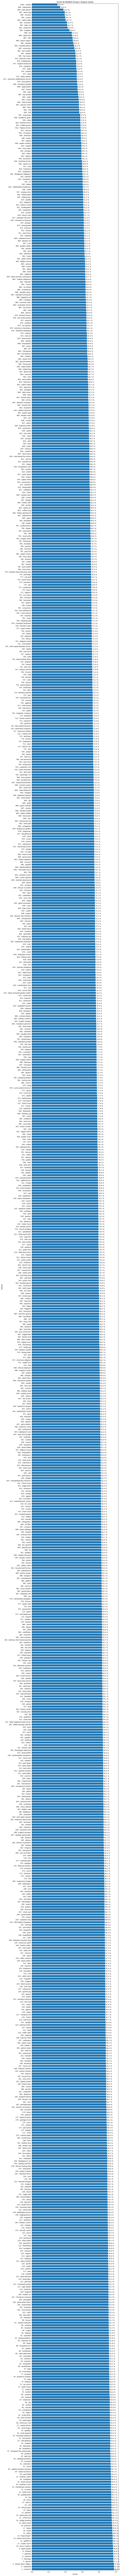

Temps d'exécution : 12.924563646316528 s.


In [85]:
import matplotlib.pyplot as plt
import matplotlib

# Créer un diagramme en bâtons pour afficher le score du modèle sur chaque classe
start = time()
Y = sorted(per_class, reverse=True)

# X sera l'ensemble des noms de classes
X = []
for i in range(1000):
    X.append(str(i+1) + ' : ' + class_dict[list_classes[best_classes_indices[i]]][0])
    
plt.figure(figsize=(10,300))
plt.margins(y=0) # remove the blanks under and above the graph
plt.title("Score de ResNet-50 pour chaque classe")
plt.barh(X,Y)
plt.xlabel('Scores')
plt.ylabel('Classes')

for index,value in enumerate(Y):
    plt.text(value, index-0.25, ' '+str(round(round(value,3)*100,1))+' %')

plt.show()

end = time()
print(f"Temps d'exécution : {end-start} s.")

La pire classe étant la classe "maillot" avec un score de 30,5%, nous travaillerons dorénavant sur cette classe pour déterminer la meilleure méthode d'agrétation pour la prédiction conforme.

### Plan

On fait $N$ runs. A chaque run $i$, on tire $K$ images aléatoirement. A chaque image $k\in\{1,\dots,K\}$, on calcule $\Gamma_k$ et $\mathbb{1}\{c\in\Gamma_k^i\}$.

Une fois les 50 runs faits, on calcule l'erreur moyenne $E_k$ sur les $N$ runs à l'étape $k$ :
<center>\[E_k = \frac{1}{N}\sum_{i=1}^N \mathbb{1}\{c\in\Gamma_k^i\} \]</center>
pour chaque étape $k$. Pour $\Gamma_k^i$, on choisit la méthode d'aggrégation comme avant. Si tout se passe bien, l'erreur $E_k$ devrait décroître et converger.

Plus simplement, on fait comme avant, mais cette fois-ci on fait $N$ runs et on calcule la moyenne des erreurs à chaque étape $k$. Dans ce cas, $E_k$ devrait bien converger vers 0.

## Stratégie 0 : Union et intersection

#### Union

In [4]:
def CP_v2_union(alpha = 0.1, N = 50, K = 50, num_classe = 638):
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    liste_images = os.listdir(chemin_classe)
    
    Matrice_erreurs_Gamma = np.zeros((N,K))
    Tailles_Gamma = np.zeros((N,K))
    
    # Pour chaque run i
    for i in range(N):
        all_C = []
        for k in range(K):
            # On choisit aléatoirement une image de la classe num_classe
            x = random.choice(liste_images)
            C = set()

            preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
            preds_index = preds.argsort()[::-1]
            preds_sorted = sorted(preds, reverse=True)
            
            somme = 0
            j = 0
            while somme <= 1-alpha:
                somme += preds_sorted[j]
                C.add(list_classes[preds_index[j]])
                j += 1
            all_C.append(C)
            
            Gamma = set.union(*all_C)
            
            Tailles_Gamma[i,k] = len(Gamma)
            Matrice_erreurs_Gamma[i,k] = 1 if nom_classe not in Gamma else 0
            
    Moy_err_Gamma = np.mean(Matrice_erreurs_Gamma, axis=0)
    Tailles_moy = np.mean(Tailles_Gamma, axis = 0)
    
    return Moy_err_Gamma, Tailles_moy

In [5]:
start = time()
N,K = 10,50
Erreurs_moy,Tailles_moy = CP_v2_union(N=N, K=K, alpha=0.05)
print('Temps :', time()-start, 's')

I0000 00:00:1730887773.372264     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Temps : 46.56972670555115 s


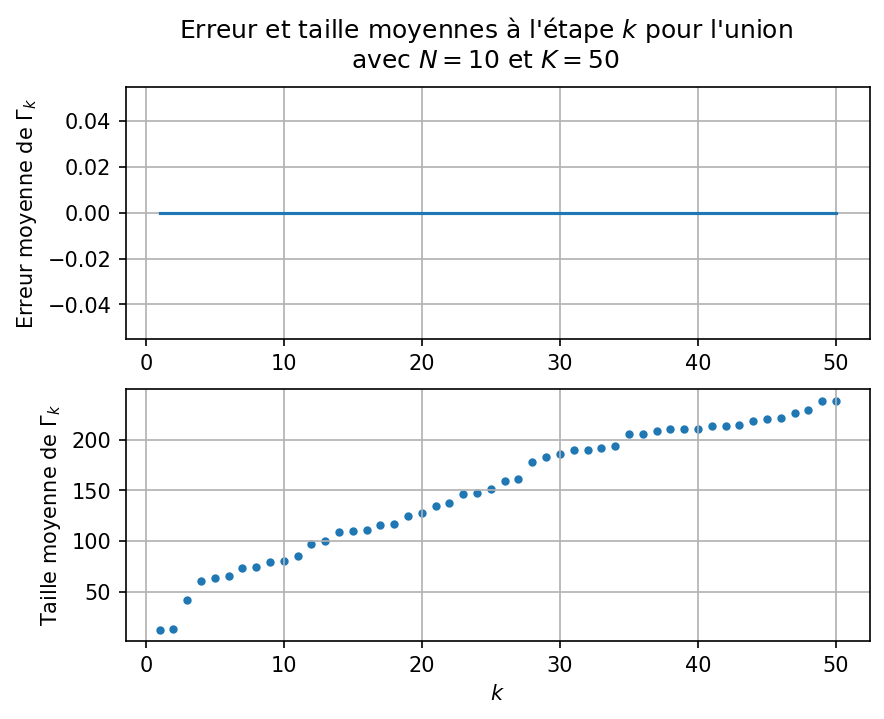

In [6]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()

plt.suptitle(r"Erreur et taille moyennes à l'étape $k$ pour l'union"
             + '\n' + r"avec $N = {}$ et $K = {}$".format(N,K))

#plt.margins(x=0,y=0)

#plt.savefig(f"Union pour N={N} et K={K}.png")

plt.show()

#### Intersection

In [7]:
def CP_v2_intersection(alpha = 0.1, N = 50, K = 50, num_classe = 638):
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    liste_images = os.listdir(chemin_classe)
    
    Matrice_erreurs_Gamma = np.zeros((N,K))
    Tailles_Gamma = np.zeros((N,K))
    
    # Pour chaque run i
    for i in range(N):
        Intersection = set(list_classes)
        for k in range(K):
            # On choisit aléatoirement une image de la classe num_classe
            x = random.choice(liste_images)
            C = set()

            preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
            preds_index = preds.argsort()[::-1]
            preds_sorted = sorted(preds, reverse=True)
            
            somme = 0
            j = 0
            while somme <= 1-alpha:
                somme += preds_sorted[j]
                C.add(list_classes[preds_index[j]])
                j += 1
            
            Intersection &= C
            
            Tailles_Gamma[i,k] = len(Intersection)
            Matrice_erreurs_Gamma[i,k] = 1 if nom_classe not in Intersection else 0
            
    Moy_err_Gamma = np.mean(Matrice_erreurs_Gamma, axis=0)
    Tailles_moy = np.mean(Tailles_Gamma, axis = 0)
    
    return Moy_err_Gamma, Tailles_moy

In [8]:
start = time()
N,K = 10,50
Erreurs_moy,Tailles_moy = CP_v2_intersection(N=N, K=K, alpha=0.05)
print('Temps :', time()-start, 's')

Temps : 37.27335238456726 s


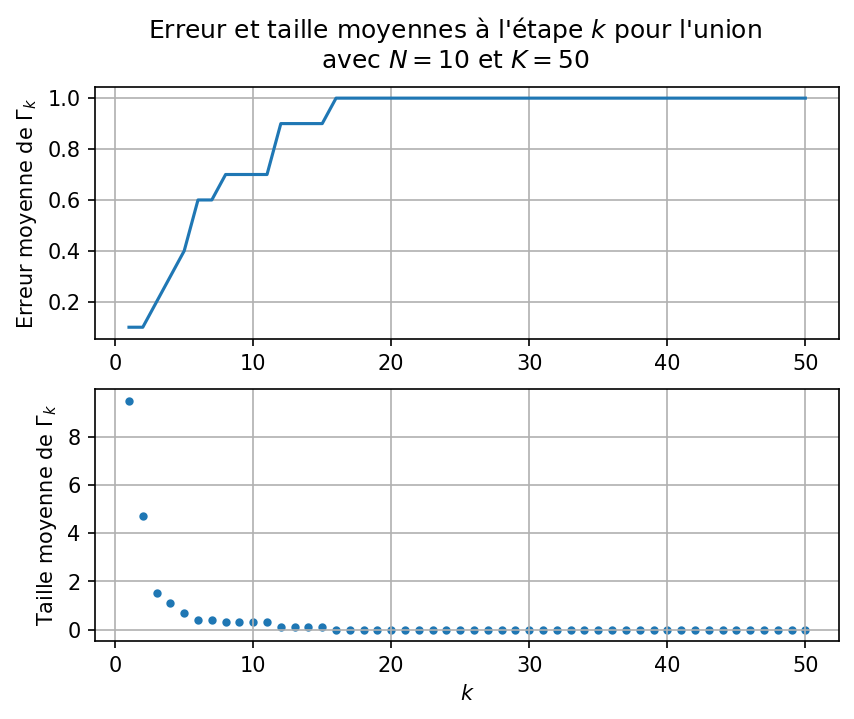

In [9]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()
#plt.margins(x=0,y=0)

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()
#plt.margins(x=0,y=0)
plt.suptitle(r"Erreur et taille moyennes à l'étape $k$ pour l'union"
             + '\n' + r"avec $N = {}$ et $K = {}$".format(N,K))

#plt.savefig(f"Intersection pour N={N} et K={K}.png")

plt.show()

La stratégie 0 est appelée ainsi car ce n'en est pas réellement une, puisque pour des raisons différentes, l'union et l'intersection ne correspondent guère à nos attentes.

## Stratégie 1 : Vote majoritaire

L'ensemble $\mathcal{C}^M$ à construire est défini par :
$$
\mathcal{C}^M = \big\{ Y\in\mathcal{Y} \mid \frac{1}{K}\sum_{k=1}^K \mathbb{1}\{Y\in\mathcal{C}_k\} > \frac{1}{2} \big\}
$$

Pour cet ensemble-là, si $\mathcal{C}_1,\ldots,\mathcal{C}_K$ sont $K \geq 2$ ensembles de confiance différents basés sur les mêmes
données, vérifiant la propriété $(1)$, alors $\mathcal{C}_M$ admet une couverture de $1-2\alpha$ :
<center> $\mathbb{P}(Y\in\mathcal{C}_M) \geq 1-2\alpha$. </center>

In [13]:
# Fonction d'agrégation pour le vote majoritaire

def majority_vote(*C,tau=0.5):
    # Equal weights for all agents
    C_M = set()
    len_C = len(C)
    for elt in set.union(*C):
        if sum(1 for k in range(len_C) if elt in C[k])/len_C > tau:
            C_M.add(elt)
    return C_M

In [13]:
class_dict[list_classes[638]]

['maillot']

In [22]:
def CP_v2_MV(alpha = 0.1, N = 50, K = 50, tau = 0.5, num_classe = 638):
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    liste_images = os.listdir(chemin_classe)
    
    Matrice_erreurs_Gamma = np.zeros((N,K))
    Tailles_Gamma = np.zeros((N,K))
    
    # Pour chaque run i
    for i in range(N):
        all_C = []
        for k in range(K):
            # On choisit aléatoirement une image de la classe num_classe
            x = random.choice(liste_images)
            C = set()

            preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
            preds_index = preds.argsort()[::-1]
            preds_sorted = sorted(preds, reverse=True)
            
            somme = 0
            j = 0
            while somme <= 1-alpha:
                somme += preds_sorted[j]
                C.add(list_classes[preds_index[j]])
                j += 1
            all_C.append(C)
            
            Gamma = majority_vote(*all_C, tau=tau)
            
            Tailles_Gamma[i,k] = len(Gamma)
            Matrice_erreurs_Gamma[i,k] = 1 if nom_classe not in Gamma else 0
            
    Moy_err_Gamma = np.mean(Matrice_erreurs_Gamma, axis=0)
    Tailles_moy = np.mean(Tailles_Gamma, axis = 0)
    
    return Moy_err_Gamma, Tailles_moy

In [5]:
start = time()
N,K = 10,50
Erreurs_moy,Tailles_moy = CP_v2_MV(N=N, K=K, alpha=0.05)
print('Temps :', time()-start, 's')

I0000 00:00:1730835520.555114     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Temps : 50.7786819934845 s


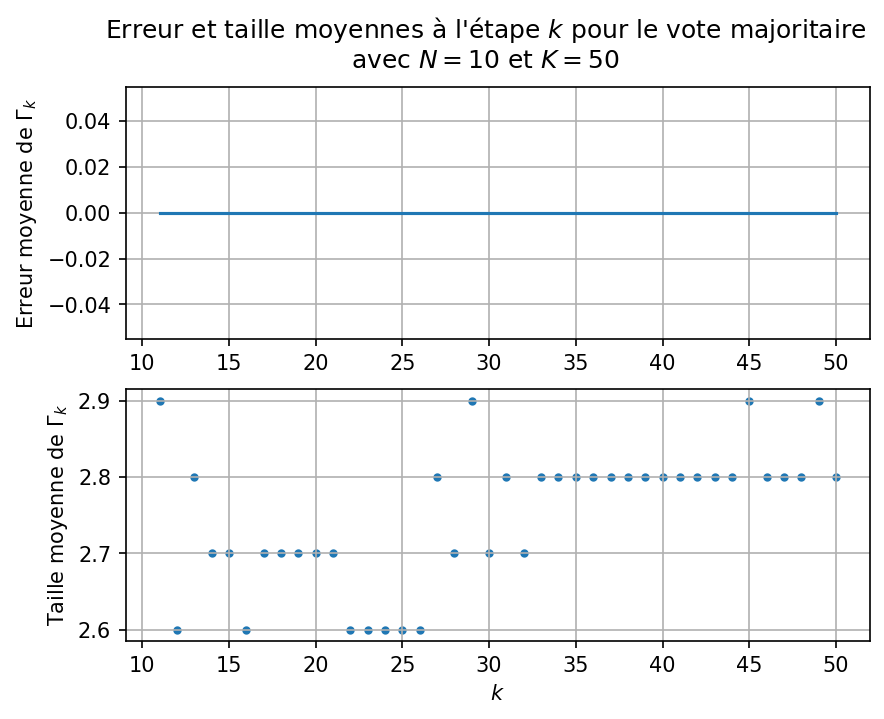

In [6]:
d = 40

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()
#plt.margins(x=0,y=0)

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()
#plt.margins(x=0,y=0)
plt.suptitle(r"Erreur et taille moyennes à l'étape $k$ pour le vote majoritaire"
             + '\n' + r"avec $N = {}$ et $K = {}$".format(N,K))

#plt.savefig(f"Vote majoritaire avec N={N} et K={K} (k={K-d+1} à 50).png")

plt.show()

## Mesure de conformité

Lorsqu'un ensemble de prédictions est construit, la **mesure de conformité** d'une classe est la probabilité que cette classe soit correcte.

In [33]:
def softmax(v):
    # Vecteur ligne v en argument
    v = np.array(v)
    exp = np.exp(v)
    
    return exp/sum(exp)

Pour obtenir le score de conformité d'une classe de $\Gamma$, nous avons besoin des probabilités de toutes les classes, issues de la fonction softmax utilisée dans le modèle de ML. Comme score de conformité, on en prend la moyenne sur les $K$ répétitions de l'expérience. Si on veut mettre à l'échelle les scores des classes présentes dans $\Gamma$ seulement, on peut utiliser la fonction softmax sur ce vecteur.

In [14]:
def CP_MV_conformity(alpha = 0.05, K = 10, tau = 0.5, num_classe = 638):
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    liste_images = os.listdir(chemin_classe)
    
    Preds = np.zeros((K,1000))
    all_C = []
    
    for i in range(K):
        x = random.choice(liste_images)
        liste_images.pop(liste_images.index(x))
        C = set()
        
        # Vecteur ligne probabilités softmax
        preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
        preds_sorted = sorted(preds, reverse = True)
        preds_index = preds.argsort()[::-1]
        Preds[i,:] = preds
        
        j = 0
        somme = 0
        while somme <= 1-alpha:
            somme += preds_sorted[j]
            C.add(list_classes[preds_index[j]])
            j += 1
        all_C.append(C)
        
    Gamma = list(majority_vote(*all_C, tau=tau))
    Moy_probas = np.mean(Preds, axis = 0)
    
    # Non-conformity scores based on Preds
    NC_scores = [Moy_probas[list_classes.index(classe)] for classe in Gamma]
    
    return Gamma,NC_scores

In [8]:
num_classe = best_classes_indices[-1]
Gamma,NC_scores = CP_MV_conformity(K=10, num_classe=num_classe,tau=0.5)
print(Gamma,'\n',NC_scores,'\n',list_classes[num_classe])

I0000 00:00:1730656048.267353     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


['n03710721', 'n03710637', 'n02837789'] 
 [0.20183812257600947, 0.31517211999744177, 0.119457102753222] 
 n03710637


## Evolution du score de conformité

Pour une méthode d'agrégation donnée, on récupère en sortie le score de conformité de notre classe et on suit son évolution en fonction de $K$.

Ce qui serait intéressant, ça serait de le faire pour le vote majoritaire généralisé pour différentes valeurs de $\tau$.

In [15]:
# Vote majoritaire
def scores_conformite(alpha=0.05, tau=0.5, K=30, num_classe=638):
    Scores = []
    for k in range(1,K+1):
        Gamma,NC_scores = CP_MV_conformity(alpha=alpha, K=k, tau=tau, num_classe=num_classe)

        if list_classes[num_classe] in Gamma:
            score = NC_scores[Gamma.index(list_classes[num_classe])]
            Scores.append(score)
        else:
            Scores.append(0)
            
    return Scores

In [16]:
K = 50
tau = 0.75
start = time()
Scores = scores_conformite(K=K, tau=tau)
print("Temps écoulé :",time()-start,'s.')

Temps écoulé : 95.50014114379883 s.


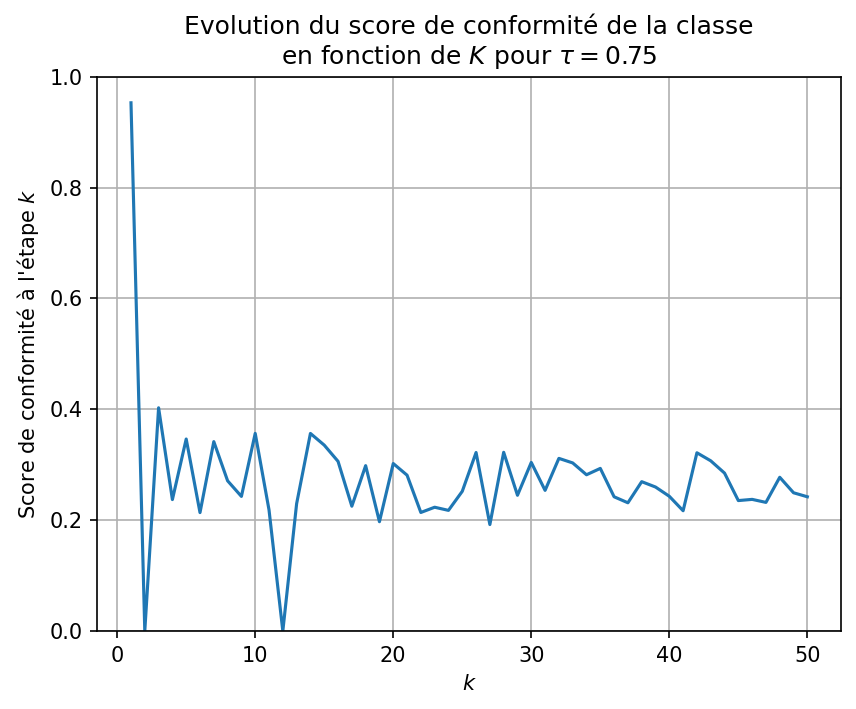

In [17]:
plt.figure(dpi=150)

plt.plot(range(1,K+1),Scores)
plt.ylim((0,1))
plt.xlabel(r'$k$')
plt.ylabel(r"Score de conformité à l'étape $k$")
plt.title("Evolution du score de conformité de la classe" + '\n' + r"en fonction de $K$ pour $\tau={}$".format(tau))
plt.grid()

#plt.savefig(f"Score de conformité pour tau={tau}.png", dpi = 150)

plt.show()

## Stratégie 1bis : Vote majoritaire généralisé

On peut généraliser le vote majoritaire en prenant pour seuil un nombre $\tau\in]0,1[$ quelconque. L'ensemble $\mathcal{C}^\tau$ alors construit est défini par :
$$
\mathcal{C}^\tau = \big\{ Y\in\mathcal{Y} \mid \frac{1}{K}\sum_{k=1}^K \mathbb{1}\{Y\in\mathcal{C}_k\} > \tau \big\}.
$$

Pour cet ensemble-là, si $\mathcal{C}_1,\ldots,\mathcal{C}_K$ sont $K \geq 2$ ensembles de confiance différents basés sur les mêmes
données, vérifiant la propriété $(1)$, alors :
<center> $\mathbb{P}(Y\in\mathcal{C}^\tau) \geq 1-\frac{\alpha}{1-\tau}$. </center>

Avec les mêmes hypothèses que précédemment, si $\mathcal{C}_1,\ldots,\mathcal{C}_K$ ont une couverture exacte de $1-\alpha$, alors pour $\tau\in ]0,1[$:
<center> $\mathbb{P}(Y\in\mathcal{C}^\tau) \leq 1 - \frac{K\alpha - \lceil K(1-\tau) \rceil + 1}{K - \lceil K(1-\tau) \rceil + 1}$. </center>

## Bornes inférieure et supérieure de $\mathbb{P}(Y\in\mathcal{C}_k)$

In [18]:
# Graphique interactif
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def plot_bornes_proba(alpha = 0.1, K = 20, grid=False):
    plt.figure(figsize = (6,6))

    plt.title(r"Bornes inférieure et supérieure de $\mathbb{P}(Y\in\mathcal{C}^\tau)$"
              + '\n' + r"avec K = {} et $\alpha = {}$".format(K,alpha))
    """
    plt.plot([1,1],[0,1], c = 'black', ls = '--')
    plt.plot([0,1],[1,1], c = 'black', ls = '--')
    plt.plot([0,0],[0,1], c = 'black', ls = '--')
    plt.plot([0,1],[0,0], c = 'black', ls = '--')
    """
    # Borne inférieure
    Tau = np.linspace(0,1-alpha,50*2)
    Y = 1-alpha/(1-Tau)
    plt.plot(Tau,Y,label = 'Borne inférieure', color = 'red')

    # Borne supérieure
    seuil = 1 - np.ceil(K*alpha)/K
    Tau = np.linspace(seuil,1,50*2)
    Sup_Proba = 1 - (K*alpha - np.ceil(K*(1-Tau)) + 1)/(K - np.ceil(K*(1-Tau)) + 1)
    plt.scatter(Tau,Sup_Proba, marker = '.',
                label = 'Borne supérieure', color = 'steelblue')

    # Borne supérieure lissée
    Tau = np.linspace(1-alpha-1/(2*K),1,50*2)
    Y = 2*K*(1-alpha)/(2*K*Tau + 1)

    plt.plot(Tau,Y, color = 'dodgerblue', ls = '--')

    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$\mathbb{P}(Y\in\mathcal{C}^\tau)$')
    plt.grid(grid)
    plt.axis('equal')

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.margins(x=0)
    plt.margins(y=0)

    plt.legend()

    # Sauvegarder le graphe comme image PNG
    #plt.savefig("Encadrement C^tau pour K={} et alpha={}.png".format(K,alpha))
    #plt.savefig("Borne inférieure de P(Y\in C^tau) avec alpha={}.png".format(alpha))

    plt.show()

In [20]:
ipywidgets.interact(plot_bornes_proba, alpha = (0,1,0.05), K = (2,100,2), grid=False)

interactive(children=(FloatSlider(value=0.1, description='alpha', max=1.0, step=0.05), IntSlider(value=20, des…

<function __main__.plot_bornes_proba(alpha=0.1, K=20, grid=False)>

Affichons les résultats pour différentes valeurs de $\tau$, par exemple pour $\tau \in \{0.1,0.25,0.5,0.75,0.9\}$.

In [25]:
# tau = 0.1
start = time()
N,K,tau = 10,50,0.1
Erreurs_moy,Tailles_moy = CP_v2_MV(N=N, K=K, alpha=0.05,tau=tau, num_classe = best_classes_indices[0])
print('Temps :', time()-start, 's')

Temps : 38.714489221572876 s


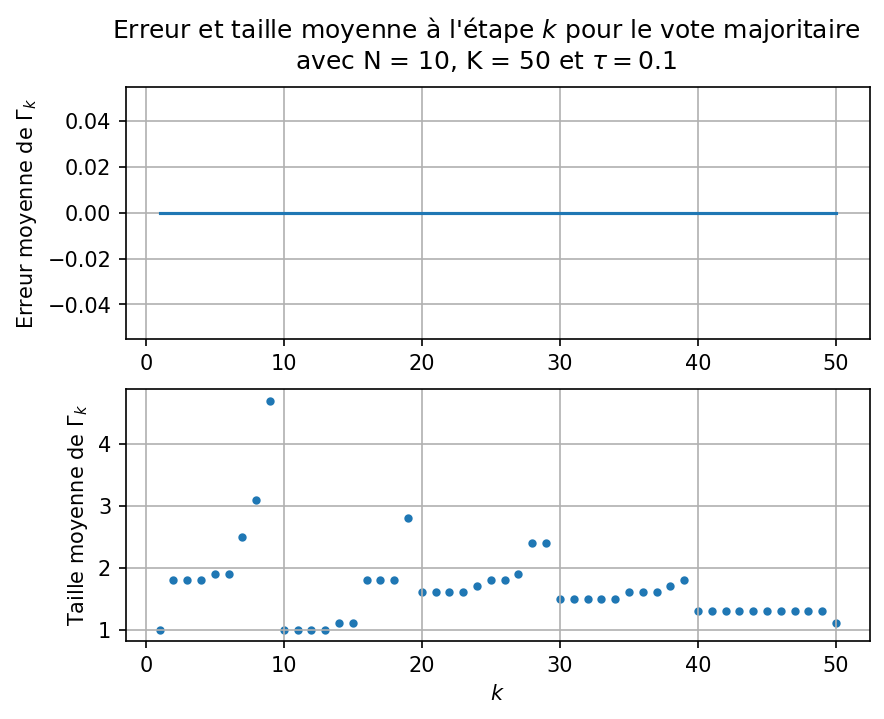

In [26]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r"$k$")
plt.grid()

plt.suptitle(r"Erreur et taille moyenne à l'étape $k$ pour le vote majoritaire"
             + '\n' + r"avec N = {}, K = {} et $\tau = {}$".format(N,K,tau))

#plt.savefig(f"VM généralisé avec tau={tau}, N={N} et K={K}.png")

plt.show()

In [ ]:
min(Tailles_moy)

In [27]:
# tau = 0.25
start = time()
N,K,tau = 10,50,0.25
Erreurs_moy,Tailles_moy = CP_v2_MV(N=N, K=K, alpha=0.05,tau=tau)
print('Temps :', time()-start, 's')

Temps : 36.940529584884644 s


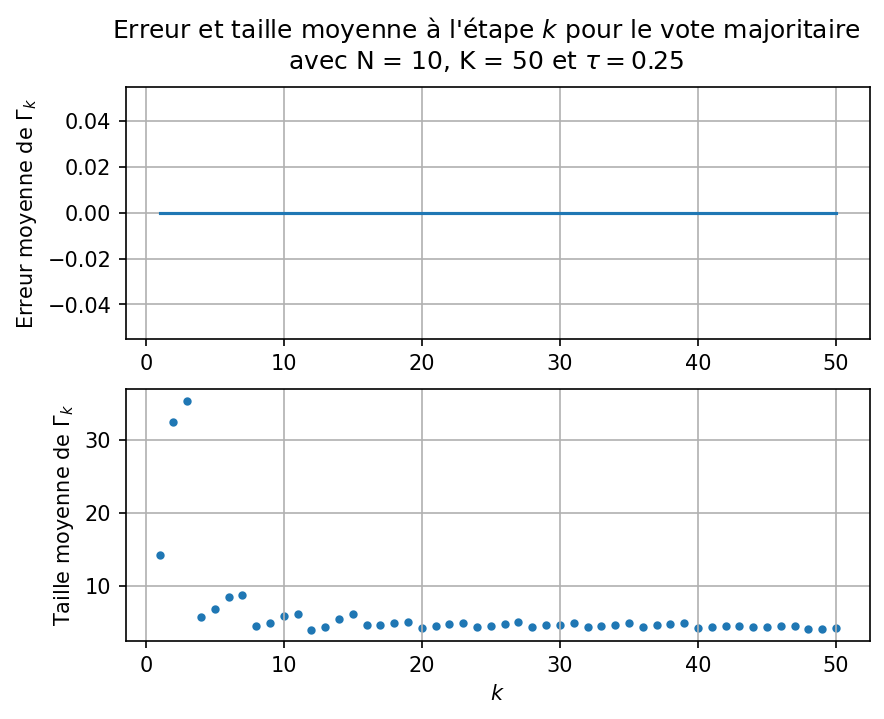

In [28]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()

plt.suptitle(r"Erreur et taille moyenne à l'étape $k$ pour le vote majoritaire"
             + '\n' + r"avec N = {}, K = {} et $\tau = {}$".format(N,K,tau))

#plt.savefig(f"VM généralisé avec tau={tau}, N={N} et K={K}.png")

plt.show()

In [ ]:
min(Tailles_moy)

In [29]:
# tau = 0.5
start = time()
N,K,tau = 10,50,0.5
Erreurs_moy,Tailles_moy = CP_v2_MV(N=N, K=K, alpha=0.05,tau=tau)
print('Temps :', time()-start, 's')

Temps : 36.71126198768616 s


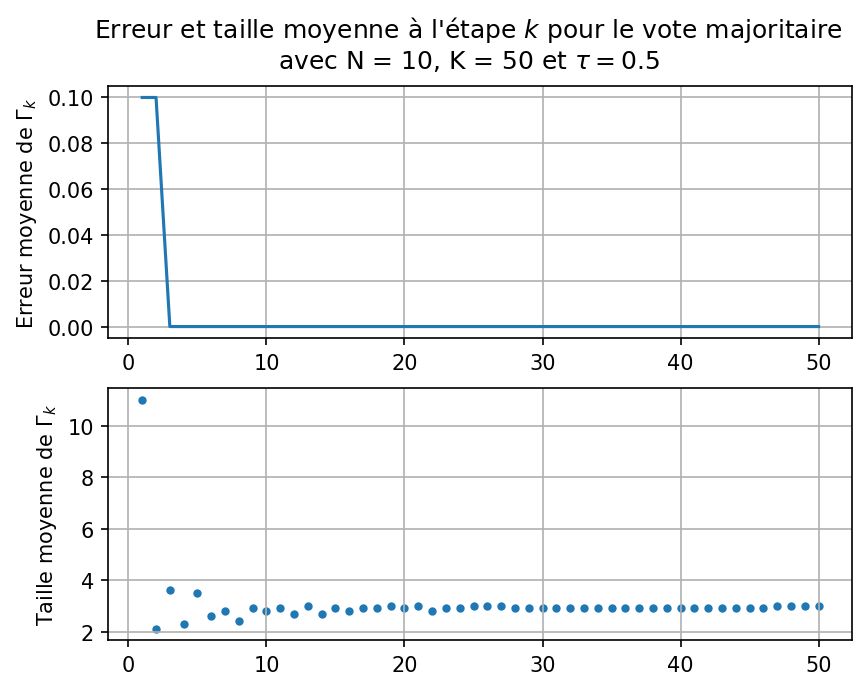

In [30]:
# Voir seulement les d derniers
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.grid()

plt.suptitle(r"Erreur et taille moyenne à l'étape $k$ pour le vote majoritaire"
             + '\n' + r"avec N = {}, K = {} et $\tau = {}$".format(N,K,tau))
plt.show()

In [ ]:
min(Tailles_moy)

In [31]:
# tau = 0.75
start = time()
N,K,tau = 10,50,0.75
Erreurs_moy,Tailles_moy = CP_v2_MV(N=N, K=K, alpha=0.05,tau=tau)
print('Temps :', time()-start, 's')

Temps : 36.859102964401245 s


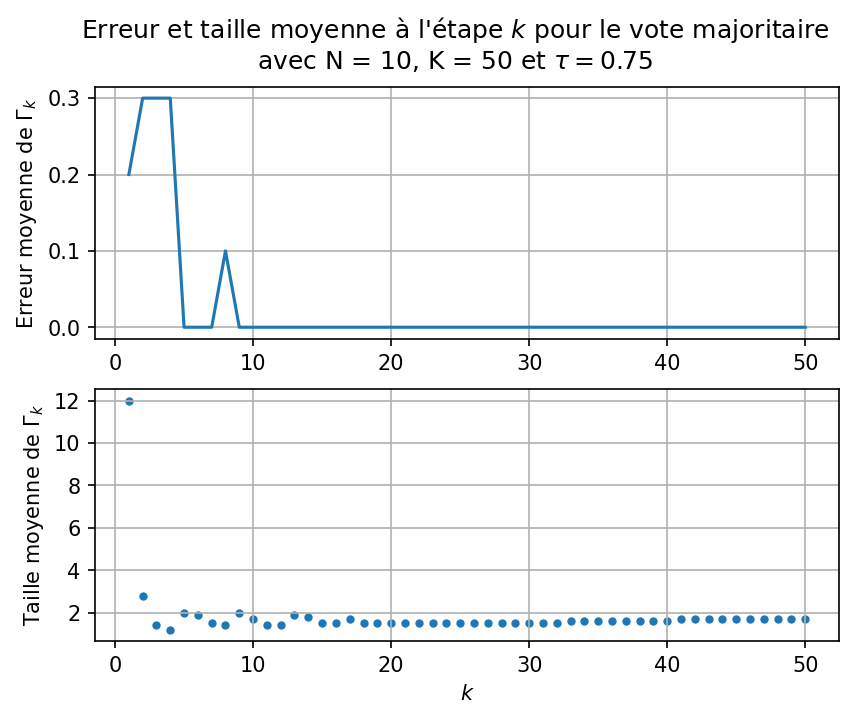

In [32]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()

plt.suptitle(r"Erreur et taille moyenne à l'étape $k$ pour le vote majoritaire"
             + '\n' + r"avec N = {}, K = {} et $\tau = {}$".format(N,K,tau))

#plt.savefig(f"VM généralisé avec tau={tau}, N={N} et K={K} (k={K-d+1} à {K}).png")

plt.show()

In [ ]:
min(Tailles_moy)

In [35]:
# tau = 0.85
start = time()
N,K,tau = 10,50,0.85
Erreurs_moy,Tailles_moy = CP_v2_MV(N=N, K=K, alpha=0.05,tau=tau)
print('Temps :', time()-start, 's')

Temps : 36.36944317817688 s


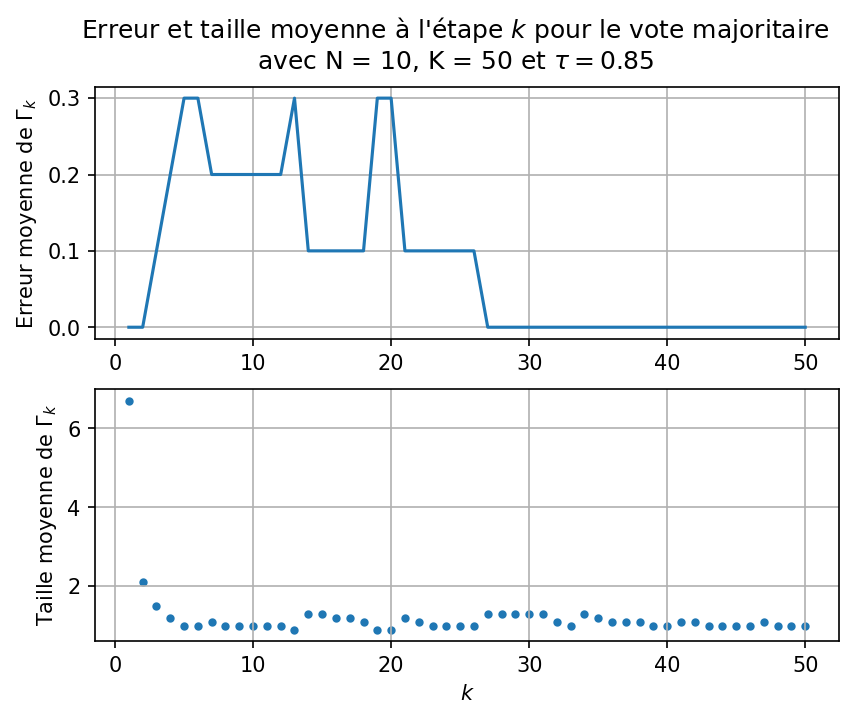

In [36]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1),Erreurs_moy[-d:])
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1),Tailles_moy[-d:], marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()

plt.suptitle(r"Erreur et taille moyenne à l'étape $k$ pour le vote majoritaire"
             + '\n' + r"avec N = {}, K = {} et $\tau = {}$".format(N,K,tau))#

#plt.savefig(f"VM généralisé avec tau={tau}, N={N} et K={K} (k={K-d+1} à {K}).png")

plt.show()

## Stratégie 2 : $\alpha$-quantile $Q_K(\alpha)$

On définit le seuil $Q_K(\alpha) := sup\{x \mid F(x) \leq \alpha\}$ où $F$ est la fonction de répartition de $\mathcal{B}(K,1-\alpha)$. L'ensemble de prédictions $\mathcal{C}^M_Q$ qui en résulte se définit comme suit :

<center> \[\mathcal{C}^M_Q := \big\{s\in\mathcal{S} \mid \sum_{k=1}^K \mathbb{1}\{s \in \mathcal{C}_k\} > Q_K(\alpha)\big\}\] </center>

Si $\mathcal{C}_1,\ldots,\mathcal{C}_K$ sont $K\geq 2$ ensembles de prédiction vérifiant la propriété $(1)$, alors l'ensemble $\mathcal{C}^M_Q$ vérifie :
<center> $\mathbb{P}(Y\in\mathcal{C}^M_Q) \geq 1-\alpha$. </center>

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# On définit Q_K(alpha) comme dans l'article "Merging uncertainty sets via majority vote"
def Q(K,alpha):
    return binom.ppf(alpha,K,1-alpha)-1

# Ensemble de predictions C^M_Q défini au-dessus
def alpha_quantile_majority_set(*C,alpha):
    len_C = len(C)
    C_M = set()
    quantile = Q(len_C,alpha)
    for k in set.union(*C):
        if sum(1 for j in range(len_C) if k in C[j]) > quantile:
            C_M.add(k)
    return C_M

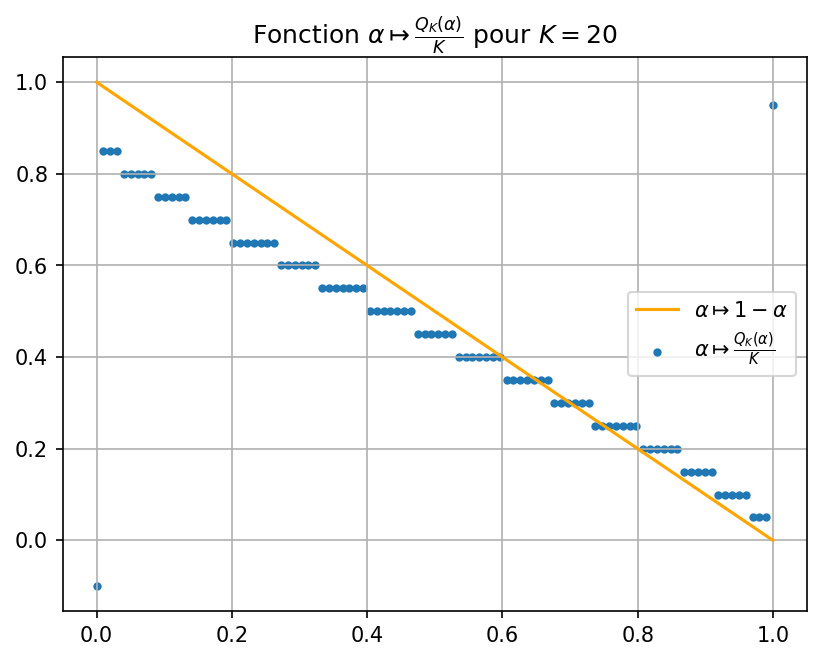

In [39]:
K = 20

Alpha = np.linspace(0,1,100)

plt.figure(dpi=150)

plt.plot(Alpha,1-Alpha, label = r"$\alpha\mapsto 1-\alpha$", c = 'orange')
plt.scatter(Alpha,Q(K,Alpha)/K,marker='.', label = r"$\alpha \mapsto \frac{Q_K(\alpha)}{K}$")

plt.title(r"Fonction $\alpha \mapsto \frac{Q_K(\alpha)}{K}$" + r" pour $K={}$".format(K))
plt.grid()
plt.legend()

plt.show()

In [40]:
def CP_v2_quantile(alpha = 0.1, N = 10, K = 50, num_classe = 638):
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    
    Matrice_erreurs_Gamma = np.zeros((N,K))
    Tailles_Gamma = np.zeros((N,K))
    
    # Pour chaque run i
    for i in range(N):
        liste_images = os.listdir(chemin_classe)
        all_C = []
        for k in range(K):
            # On choisit aléatoirement une image de la classe num_classe
            x = random.choice(liste_images)
            liste_images.pop(liste_images.index(x))
            C = set()

            preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
            preds_index = preds.argsort()[::-1]
            preds_sorted = sorted(preds, reverse=True)
            
            somme = 0
            j = 0
            while somme < 1-alpha:
                somme += preds_sorted[j]
                C.add(list_classes[preds_index[j]])
                j += 1
            all_C.append(C)
            
            Gamma = alpha_quantile_majority_set(*all_C, alpha=alpha)
            
            Tailles_Gamma[i,k] = len(Gamma)
            Matrice_erreurs_Gamma[i,k] = 1 if nom_classe not in Gamma else 0
            
    Moy_err_Gamma = np.mean(Matrice_erreurs_Gamma, axis=0)
    Tailles_moy = np.mean(Tailles_Gamma, axis = 0)
    
    return Moy_err_Gamma,Tailles_moy

In [41]:
start = time()
N,K = 10,50
Erreurs_moy,Tailles_moy = CP_v2_quantile(N=N, K=K, alpha=0.05)
print('Temps :', time()-start, 's')

Temps : 37.76008605957031 s


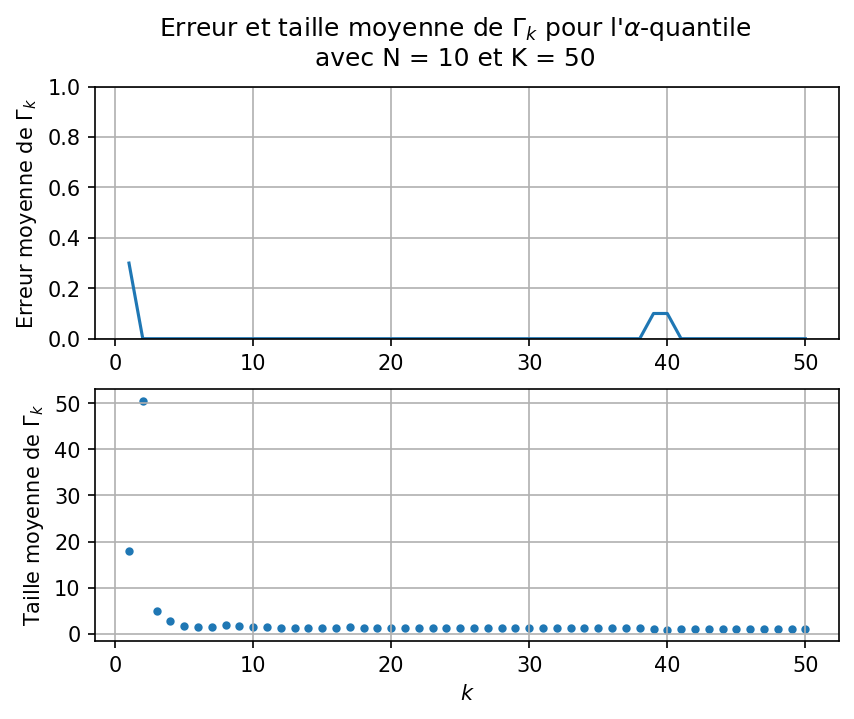

In [44]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1), Erreurs_moy[-d:])
plt.ylim((0,1))
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1), Tailles_moy[-d:], marker =  '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()

plt.suptitle(r"Erreur et taille moyenne de $\Gamma_k$ pour l'$\alpha$-quantile"
             + "\n" + f"avec N = {N} et K = {K}")

#plt.savefig(f"Quantile N={N} et K={K}_figure 3.png", dpi = 150)

plt.show()

## Score de conformité pour le quantile

In [45]:
def CP_quantile_conformity(alpha = 0.05, K = 10, num_classe = 638):
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    liste_images = os.listdir(chemin_classe)
    
    Preds = np.zeros((K,1000))
    all_C = []
    
    for i in range(K):
        x = random.choice(liste_images)
        liste_images.pop(liste_images.index(x))
        C = set()
        
        # Vecteur ligne probabilités softmax
        preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
        preds_sorted = sorted(preds, reverse = True)
        preds_index = preds.argsort()[::-1]
        Preds[i,:] = preds
        
        j = 0
        somme = 0
        while somme <= 1-alpha:
            somme += preds_sorted[j]
            C.add(list_classes[preds_index[j]])
            j += 1
        all_C.append(C)
        
    Gamma = list(alpha_quantile_majority_set(*all_C, alpha=alpha))
    Moy_probas = np.mean(Preds, axis = 0)
    
    # Non-conformity scores based on Preds
    NC_scores = [Moy_probas[list_classes.index(classe)] for classe in Gamma]
    
    return Gamma,NC_scores

In [28]:
num_classe = best_classes_indices[-1]
Gamma,NC_scores = CP_quantile_conformity(K=10, num_classe=num_classe)
print(Gamma,'\n',NC_scores,'\n',list_classes[num_classe])

['n03710637', 'n03710721', 'n02837789'] 
 [0.40445957351475953, 0.24725978104252136, 0.12444323219824582] 
 n03710637


## Evolution du score de conformité quantile

Pour une méthode d'agrégation donnée, on récupère en sortie le score de conformité de notre classe et on suit son évolution en fonction de $K$.

Ce qui serait intéressant, ça serait de le faire pour le vote majoritaire généralisé pour différentes valeurs de $\tau$.

In [46]:
# Quantile
def scores_conformite_quantile(alpha=0.05, K=30, num_classe=638):
    Scores = []
    for k in range(1,K+1):
        Gamma,NC_scores = CP_quantile_conformity(alpha=alpha, K=k, num_classe=num_classe)

        if list_classes[num_classe] in Gamma:
            score = NC_scores[Gamma.index(list_classes[num_classe])]
            Scores.append(score)
        else:
            Scores.append(0)
            
    return Scores

In [47]:
K = 50
start = time()
Scores = scores_conformite_quantile(K=K)
print("Temps écoulé :",time()-start,'s.')

Temps écoulé : 91.7431001663208 s.


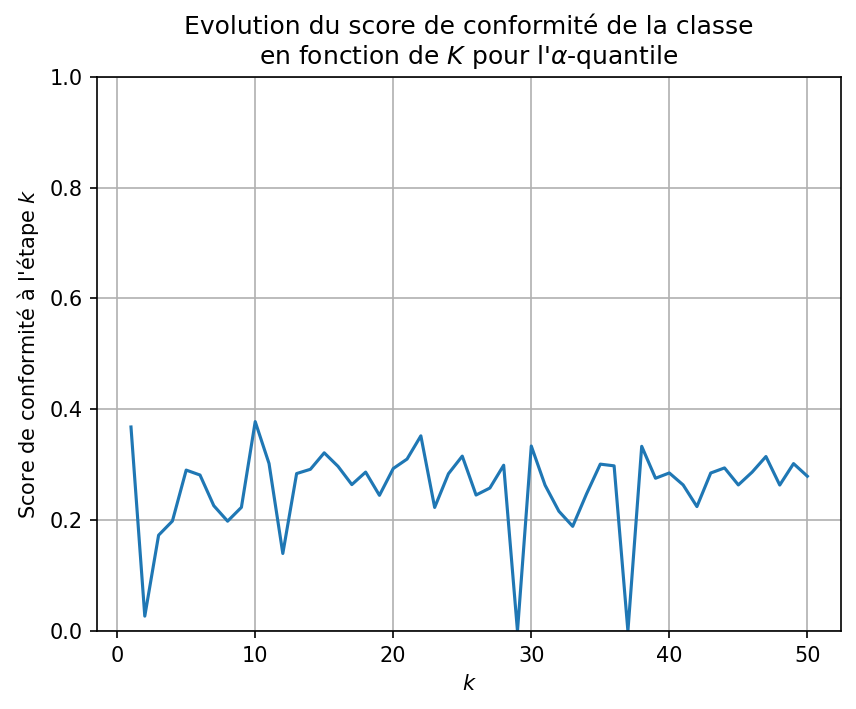

In [51]:
plt.figure(dpi = 150)

plt.plot(range(1,K+1),Scores)
plt.ylim((0,1))
plt.xlabel(r'$k$')
plt.ylabel(r"Score de conformité à l'étape $k$")

plt.title(r"Evolution du score de conformité de la classe" + '\n' + r"en fonction de $K$ pour l'$\alpha$-quantile")
plt.grid()

#plt.savefig(f"Score de conformité quantile_figure 3.png", dpi = 150)

plt.show()

L'erreur moyenne, pour l'$\alpha$-quantile, a tendance à osciller autour d'une valeur non nulle.

In [ ]:
chemin_classe = os.path.join(imagenet_train_dir, list_classes[68])
liste_images = os.listdir(chemin_classe)
x = random.choice(liste_images)
picture = load_and_preprocess_img(os.path.join(chemin_classe, x))

preds1 = model.predict(picture, verbose = 0)[0]
preds2 = model.predict(picture, verbose = 0)[0]

all(preds1 == preds2)

# Donc les prédictions d'une même image seront identiques, quel que soit le moment

## Stratégie 3 : Intersection des $\mathcal{C}^M(1:k)$ intermédiaires

Définissons, pour $k\in\{1,\ldots,K\}$, l'ensemble $\mathcal{C}^M(1:k)$ comme l'agrégation, par le vote majoritaire, des ensembles $\mathcal{C}_1,\ldots,\mathcal{C}_k$. On définit l'ensemble $\mathcal{C}^E$ comme l'intersection des votes majoritaires intermédiaires :
<center> \[\mathcal{C}^E = \bigcap_{k=1}^K \mathcal{C}^M(1:k)\] </center>

In [56]:
def CP_v2_intersect_MV(alpha = 0.1, N = 50, K = 50, tau = 0.5, num_classe = 638):
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    
    Matrice_erreurs_Gamma = np.zeros((N,K))
    Tailles_Gamma = np.zeros((N,K))
    
    # Pour chaque run i
    for i in range(N):
        liste_images = os.listdir(chemin_classe)
        all_C = []
        Intersection = set(list_classes)
        for k in range(K):
            # On choisit aléatoirement une image de la classe num_classe
            x = random.choice(liste_images)
            liste_images.pop(liste_images.index(x))
            C = set()

            preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
            preds_index = preds.argsort()[::-1]
            preds_sorted = sorted(preds, reverse=True)
            
            somme = 0
            j = 0
            while somme <= 1-alpha:
                somme += preds_sorted[j]
                C.add(list_classes[preds_index[j]])
                j += 1
            all_C.append(C)
            
            Intersection &= majority_vote(*all_C, tau=tau)

            Tailles_Gamma[i,k] = len(Intersection)
            Matrice_erreurs_Gamma[i,k] = 1 if nom_classe not in Intersection else 0
            
    Moy_err_Gamma = np.mean(Matrice_erreurs_Gamma, axis=0)
    Tailles_moy = np.mean(Tailles_Gamma, axis = 0)
    
    return Moy_err_Gamma,Tailles_moy

In [66]:
start = time()
N,K = 10,50
tau = 0.5
Erreurs_moy,Tailles_moy = CP_v2_intersect_MV(alpha = 0.05, num_classe = 638, N = N, K = K, tau = tau)
print(f'Temps : {time()-start} s')

Temps : 36.934916257858276 s


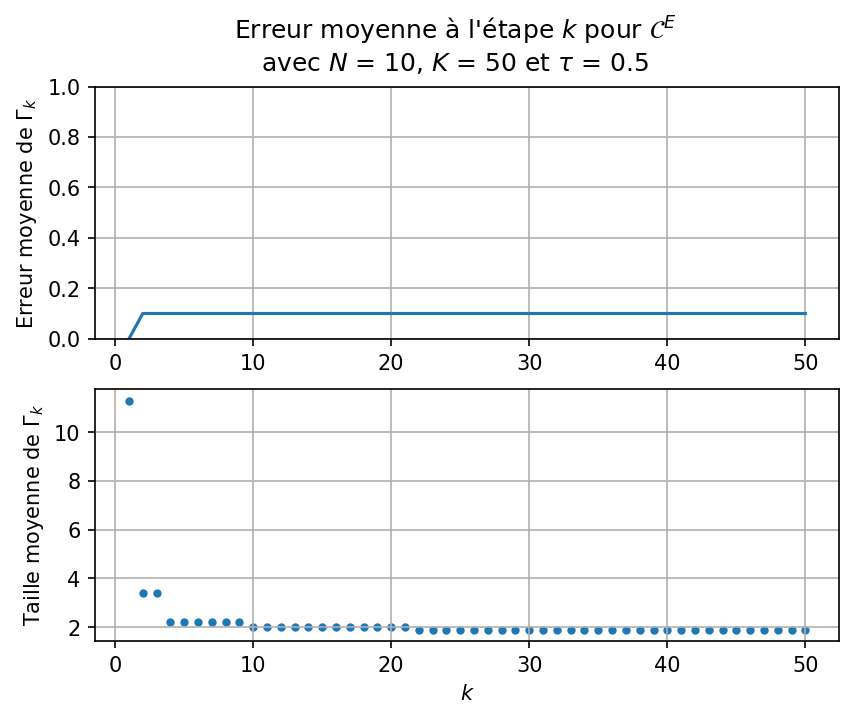

In [67]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1), Erreurs_moy[-d:])
plt.ylim((0,1))
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1), Tailles_moy[-d:], marker =  '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()

plt.suptitle(r"Erreur moyenne à l'étape $k$ pour $\mathcal{C}^E$"
             + "\n" + r"avec $N$ = {}, $K$ = {} et $\tau$ = {}".format(N,K,tau))

#plt.savefig(f"Quantile N={N} et K={K}_figure 3.png", dpi = 150)

plt.show()

## Stratégie 4 : intersection des $\mathcal{C}^M_Q$ intermédiaires

On définit l'ensemble $\mathcal{C}^E_Q$ comme l'intersection des ensembles $\mathcal{C}^M_Q$ intermédiaires :
<center> \[\mathcal{C}^E_Q = \bigcap_{k=1}^K \mathcal{C}^M_Q(1:k)\] </center>

In [69]:
def CP_intersect_quartile(alpha = 0.1, N = 50, K = 50, num_classe = 638):
    global list_classes, imagenet_train_dir
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    
    Tailles_Gamma,Matrice_erreurs_Gamma = np.zeros((N,K)),np.zeros((N,K))
    
    for n in range(N):
        liste_images = os.listdir(chemin_classe)
        all_C = []
        Intersection = set(list_classes)
        for k in range(K):
            C = set()
            x = random.choice(liste_images)
            liste_images.pop(liste_images.index(x))
            
            preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
            preds_index = preds.argsort()[::-1]
            preds_sorted = sorted(preds, reverse = True)
            
            somme = 0
            j = 0
            while somme < 1-alpha:
                somme += preds_sorted[j]
                C.add(list_classes[preds_index[j]])
                j += 1
            all_C.append(C)
            
            Intersection &= alpha_quantile_majority_set(*all_C, alpha=alpha)
            
            Matrice_erreurs_Gamma[n,k] = 1 if nom_classe not in Intersection else 0
            Tailles_Gamma[n,k] = len(Intersection)
            
    Erreurs_moy = np.mean(Matrice_erreurs_Gamma, axis = 0)
    Tailles_moy = np.mean(Tailles_Gamma, axis = 0)
    
    return Erreurs_moy,Tailles_moy

In [70]:
start = time()
N,K,alpha = 10,50,0.05
Erreurs_moy,Tailles_moy = CP_intersect_quartile(alpha=alpha, N=N, K=K)
print('Temps :', time()-start, 's')

Temps : 36.40797972679138 s


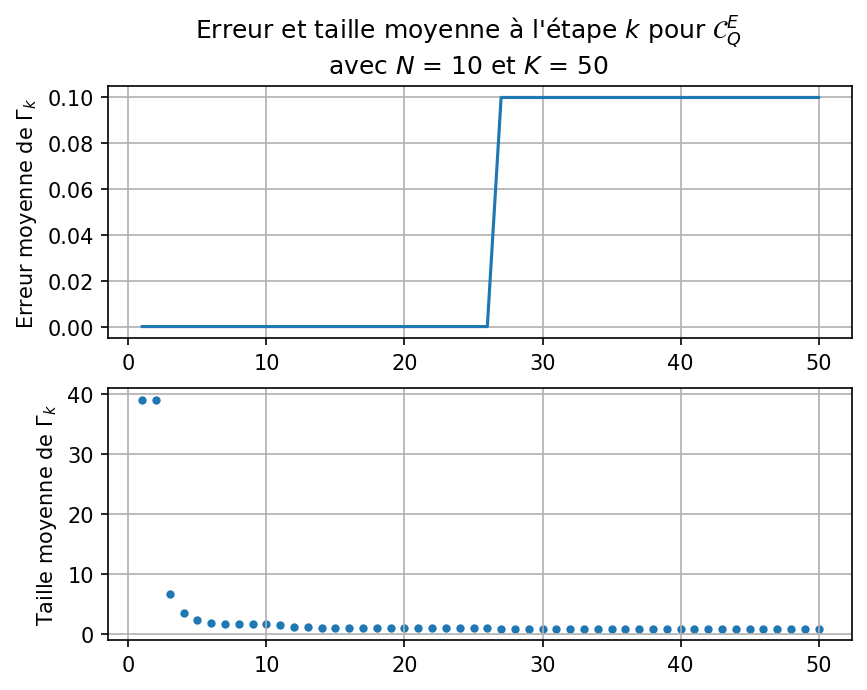

In [75]:
d = K

plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(K-d+1,K+1), Erreurs_moy[-d:], label = r'Erreur moyenne en $k$')
plt.ylabel(r"Erreur moyenne de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(K-d+1,K+1), Tailles_moy[-d:], label = r'Taille moyenne de $\Gamma_k$', marker = '.')
plt.ylabel(r"Taille moyenne de $\Gamma_k$")

plt.suptitle(r"Erreur et taille moyenne à l'étape $k$ pour $\mathcal{C}^E_Q$"
             + "\n" + r"avec $N$ = {} et $K$ = {}".format(N,K))
plt.grid()
plt.show()

## Stratégie 5 : Moyenne des probabilités de softmax

En sortie de la fonction `softmax`, le $k$-ème classifieur va donner la liste ordonnée de probabilités $(p_{k,1},p_{k,2},\ldots,p_{k,n})$. On calcule la moyenne $\bar{p}_i = \frac{1}{K}\sum_{k=1}^K p_{k,i}$ de ces probabilités sur les $K$ classifieurs, pour chaque classe $i$, ce qui nous donne une liste de 1000 probabilités. Ensuite, pour construire l'ensemble $\Gamma$, on procède comme si on construisait un ensemble $\mathcal{C}_k$.

In [77]:
def CP_moy_probas_softmax(K=50, alpha=0.05, num_classe = 638):
    # A chaque étape k, on calcule la moyenne par classe
    # des probas issues de softmax.
    # On a une liste de 1000 probas
    # Puis on construit le Gamma comme on
    # construirait tout ensemble C_k
    
    nom_classe = list_classes[num_classe]
    chemin_classe = os.path.join(imagenet_train_dir,nom_classe)
    liste_classe = os.listdir(chemin_classe)
    
    all_Gamma = []
    Matrice_preds = np.zeros((K,1000))
    Moyenne_probas = np.zeros((K,1000))
    
    Erreurs,Tailles = [],[]
    
    for k in range(K):
        x = random.choice(liste_classe)
        liste_classe.pop(liste_classe.index(x))
        
        preds = model.predict(load_and_preprocess_img(os.path.join(chemin_classe,x)), verbose = 0)[0]
        
        # `preds` est une liste np.array de taille 1000
        Matrice_preds[k,:] = preds
        
        # Moyenne des probas
        Moyenne_probas[k,:] = np.mean(Matrice_preds[:k+1,:], axis = 0)
        
        # Construction de Gamma
        preds = Moyenne_probas[k,:]
        preds_sorted = sorted(preds, reverse = True)
        preds_index = preds.argsort()[::-1]
        
        Gamma = set()
        somme = 0
        j = 0
        while somme < 1-alpha:
            somme += preds_sorted[j]
            Gamma.add(list_classes[preds_index[j]])
            j += 1
        all_Gamma.append(Gamma)
        
        Erreurs.append(1 if nom_classe not in Gamma else 0)
        Tailles.append(len(Gamma))
        
    return Erreurs,Tailles

In [81]:
start = time()
K,alpha = 50,0.05
Erreurs,Tailles = CP_moy_probas_softmax(K=K, alpha=alpha)
print("Temps :", time()-start, "s.")

Temps : 3.561213493347168 s.


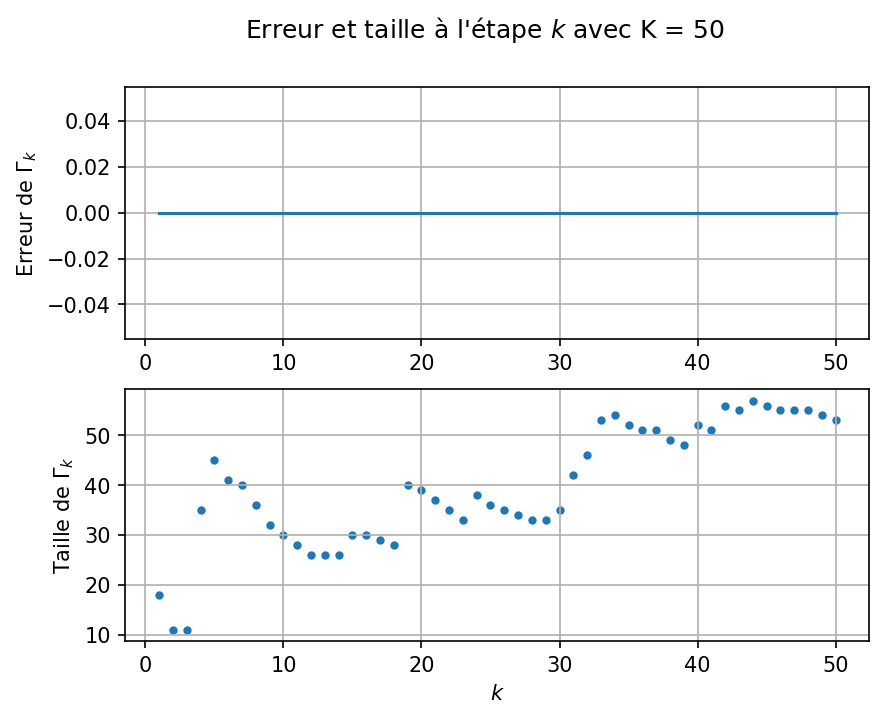

In [82]:
plt.figure(dpi = 150)

plt.subplot(2,1,1)
plt.plot(range(1,K+1), Erreurs, label = r'Erreur de $\Gamma_k$')
plt.ylabel(r"Erreur de $\Gamma_k$")
plt.grid()

plt.subplot(2,1,2)
plt.scatter(range(1,K+1), Tailles, label = r'Taille de $\Gamma_k$', marker = '.')
plt.ylabel(r"Taille de $\Gamma_k$")
plt.xlabel(r'$k$')
plt.grid()
plt.suptitle(r"Erreur et taille à l'étape $k$ avec K = {}".format(K))

#plt.savefig("Moyenne des probas softmax.png", dpi = 150)

plt.show()